# 3.2.1 Segmentation based on the short-time energy

In [9]:
# Library and audio loading

%matplotlib inline

import librosa
import librosa.display
import IPython.display
import numpy as np
import matplotlib.pyplot as plt

y, sr = librosa.core.load("/Users/felipefelix/USP/tcc/dataset/pr_article/S_A_C_Base_Parte-1/Camptostoma obsoletum/song/1000153.mp3")
y_f, sr_f = librosa.core.load("/Users/felipefelix/USP/tcc/dataset/pr_article/S_A_C_Base_Parte-1/Camptostoma obsoletum/song/1000153.mp3.filtered1.wav")
#IPython.display.Audio(data = y, rate = sr)

In [10]:
IPython.display.Audio(data = y, rate = sr)

In [11]:
IPython.display.Audio(data = y_f, rate = sr_f)

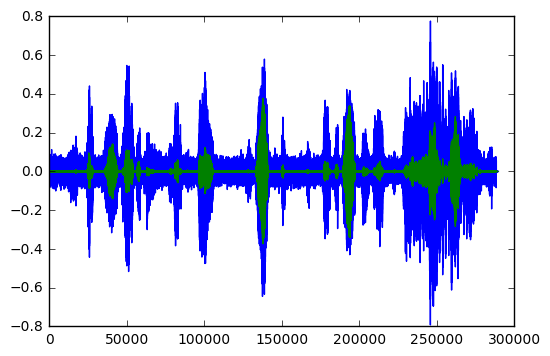

In [12]:
# Audio wave

plt.plot(y)
plt.plot(y_f)

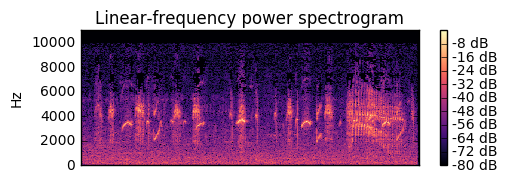

In [13]:
# Spectrogram representation

plt.figure(figsize=(12, 8))
D = librosa.amplitude_to_db(librosa.stft(y, n_fft = 2048), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

In [14]:
# Function to print all frames.

def print_frames(frames):
    n_frames = len(frames[0, :])
    for i in range(n_frames):
        print(frames[:, i])
        
# Returns the energy of a frame in decibel scale.

def energy(frame):
    return np.sum(20*np.log10(np.abs(frame)))

# Returns an array that the i-th position contains the energy
# of frames[i].

def energy_envelope(frames):
    n_frames = len(frames[0, :])
    E = np.zeros(n_frames)
    for i in range(n_frames):
        E[i] = energy(frames[:, i])
    return E

### The audio file is divided into overlapping frames. In this work: frame size is 128 samples corresponding 3ms and adjacent frames overlap 50%.

In [15]:
duration   = librosa.get_duration(y, sr)
frame_size = librosa.time_to_samples(0.003, sr = sr)[0]
hop_size   = int(frame_size * 0.5)
frames     = librosa.util.frame(y, frame_length = frame_size, hop_length = hop_size)

Energy envelope E(m) of the signal x(n) in decibel scale:
\begin{equation}
E(m) = \sum\limits_{i=1}^{N} 20log_{10}|x_m[i]|
\end{equation}
where $x_m[n]$ is m-th frame and $N$ is the total number of samples of frame $x_m$.

/Users/felipefelix/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log10


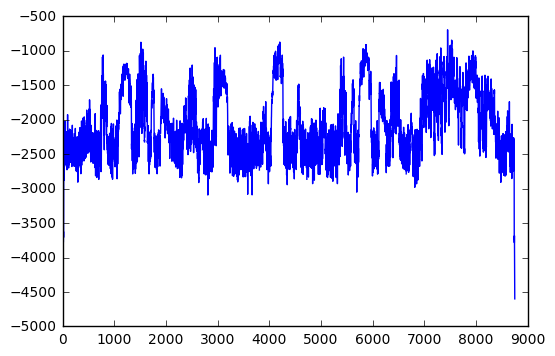

In [16]:
# Energy Envelope by frame
E = energy_envelope(frames)
plt.plot(E)

1) Initial noise level estimate is set equal to the minimum energy of E(m).  
2) Threshold for onset and offset is set to the half of the noise level.  
Flow diagram of syllable search algorithm:  
![alt text](pics/flow.png "Flow diagram of syllable search algorithm")



In [17]:
# Receives energy array. 
# Returns two lists with frame indexes for onsets and offsets.

def syllable_search(E):
    noise_level = np.min(E)
    threshold   = noise_level/2
    n_frames    = len(E)
    
    signal_marker = False

    onset  = []
    offset = []
    
    for i in range(n_frames):
        if E[i] > threshold:
            if not signal_marker:
                onset.append(i)
                signal_marker = True
                E[i] = 0
        else:
            if signal_marker:
                offset.append(i)
                signal_marker = False
                E[i] = 0
            else:
                noise_level = np.mean(E)
                threshold = noise_level/2
    return onset, offset

onset, offset = syllable_search(E)

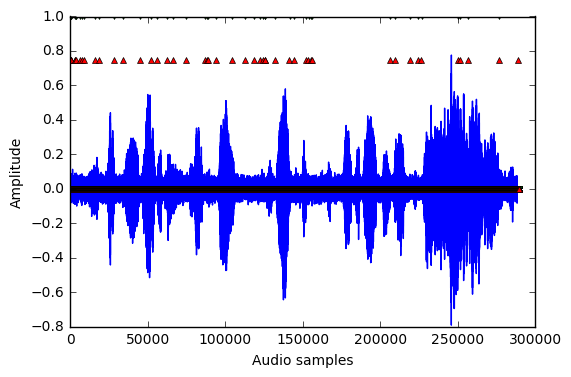

In [18]:
# Receives audio, onset and offset arrays.
# and plots the audio wave with offset/onsets markers
def plot_onsets_offsets(y, onset_s, offset_s):
    onset_s  = librosa.core.frames_to_samples(onset, hop_length = hop_size)
    offset_s = librosa.core.frames_to_samples(offset, hop_length = hop_size)

    onset_plot = np.zeros(len(y))
    onset_plot[onset_s] = 1

    offset_plot = np.zeros(len(y))
    offset_plot[offset_s] = 0.75

    plt.plot(y, 'b', onset_plot, 'gv', offset_plot, 'r^', markersize = 5)
    plt.ylabel("Amplitude")
    plt.xlabel("Audio samples")
    plt.show()

plot_onsets_offsets(y, onset, offset)

In [19]:
onset_s  = librosa.core.frames_to_samples(onset, hop_length = hop_size)
offset_s = librosa.core.frames_to_samples(offset, hop_length = hop_size)

print(offset_s)
IPython.display.Audio(data = y[onset_s[0]:offset_s[13]], rate = sr)

[   198    297    396   3201   3366   3927   6303   7359   8778  15807
  18414  28347  33891  44781  52338  55902  62436  66066  74448  86691
  88077  88968  94083 104313 112596 118668 122166 124542 125565 125895
 132264 141438 144375 151833 153681 155496 155991 206415 209616 219351
 224070 226512 250173 251559 256575 276507 288783]
